In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA
from pandas import concat


# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [6]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

# Random Forest

In [8]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [10]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)


In [11]:
rf_data = series_to_supervised(X, n_in=4)

In [12]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

### Walk-forward validation

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
# walk-forward validation for univariate data
def rf_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [16]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000, random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

>expected=7.5, predicted=15.2
>expected=7.8, predicted=8.6
>expected=3.5, predicted=10.4
>expected=3.9, predicted=7.3
>expected=6.8, predicted=6.6
>expected=2.1, predicted=6.7
MAE: 3.947
ME: 3.900
RMSE: 4.866
Direction Accuracy: 0.000


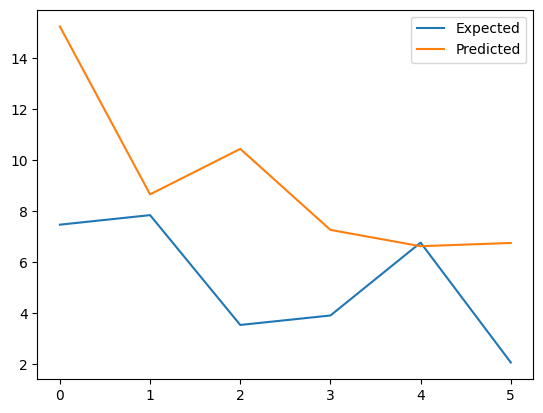

In [17]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_walk_forward_validation(rf_data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

### Static forecast for Random Forest (should be ROLLING WINDOW)

In [18]:
train, test = train_test_split(rf_data, 6)


In [19]:
train = asarray(train)

In [20]:
trainX, trainy = train[:, :-1], train[:, -1]


In [21]:
model_rf_static = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf_static.fit(trainX, trainy)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [22]:
predictions = list()
direction_accuracies = list() 

In [23]:
test[0, :-1]

array([18.51417816, 28.98555411, 16.84723416,  4.06330439])

In [24]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    yhat = model_rf_static.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


>expected=7.5, predicted=15.2
>expected=7.8, predicted=8.1
>expected=3.5, predicted=11.2
>expected=3.9, predicted=6.5
>expected=6.8, predicted=6.6
>expected=2.1, predicted=5.0


In [27]:
yhat

array([4.97428635])

In [28]:
predictions

[array([15.23229585]),
 array([8.05535681]),
 array([11.2197097]),
 array([6.50977701]),
 array([6.62761812]),
 array([4.97428635])]

In [25]:
error = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

Forecast accuracy for Static Forecast with Random Forest
MAE: 3.559
ME: 3.516
RMSE: 4.745
Direction Accuracy: 0.400


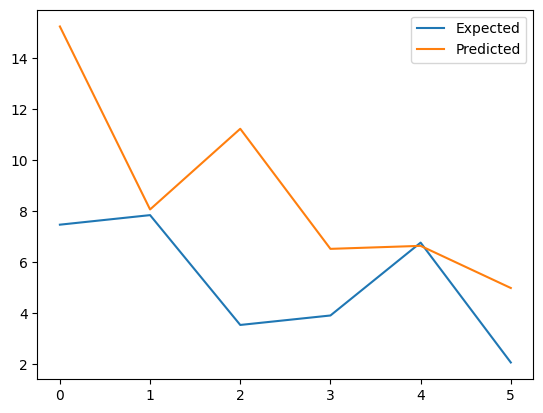

In [29]:
#print('MAE: %.3f' % mae)
print('Forecast accuracy for Static Forecast with Random Forest')
print('MAE: %.3f' % error)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [177]:
# 
def rf_staticforecast(data, n_test):
 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = model_rf_static.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [178]:
rf_static_data = series_to_supervised(X, n_in=4)

>expected=7.5, predicted=15.6
>expected=7.8, predicted=8.3
>expected=3.5, predicted=11.5
>expected=3.9, predicted=7.0
>expected=6.8, predicted=6.7
>expected=2.1, predicted=5.3
Forecast accuracy for Static Forecast with Random Forest
ME: 3.811
RMSE: 5.001
Direction Accuracy: 0.200


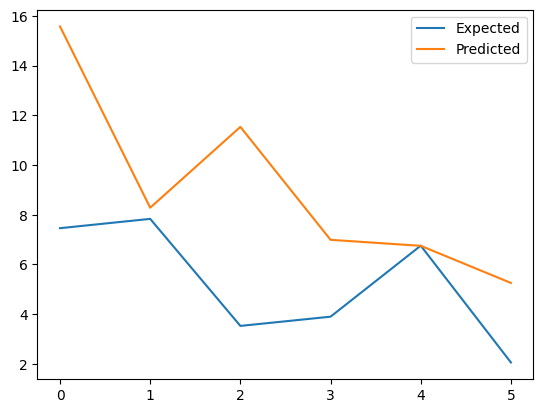

In [179]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_staticforecast(rf_static_data, 6)
#print('MAE: %.3f' % mae)
print('Forecast accuracy for Static Forecast with Random Forest')
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

Can recommend models based on what is needed - metrics or accuracy. 